In [10]:
import pandas as pd 
import numpy as np
from IPython.display import display 
import matplotlib.pyplot as plt
import seaborn as sns
import functools
import re
import warnings
import json
from cProfile import label
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve,roc_auc_score,recall_score,precision_recall_curve,auc,precision_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.utils import resample,shuffle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
from learn_curving_fold import plot_learning_curves
from imblearn.over_sampling import RandomOverSampler
import shap
import time
import copy
import joblib 

In [11]:
#file_train = 'D:/CODE/KD/datas/KeptGPT/k-fold/30/2-fold_train_z.csv'
file_test = 'D:/CODE/KD/datas/KeptGPT/k-fold/30/total-test_2_z.csv'

In [12]:
def test_prc_models(
    model =list,
    random_state_1 = 30,
    random_state_test = 30,
    model_amount = 1,
    color_origin=list,
    file_test = list,
    input_type = list,
    ):
        '''
        model : input model list
        color_origin: input color list (for origin)
        color_up :input color list(for upsample)
        input_type :for the name of your input data
        file_train : list including path for your training data
        file_test :list including path for your testing data 
        '''
        for i in range(model_amount):
                print('now in:',i+1)
                '==============================upsampling train/origin model_1======================='
                fold_test = pd.read_csv(file_test[i])
                #rename(消去columns項內非英文以及數字的解)
                fold_test = fold_test.drop(columns=['Unnamed: 0'])
                fold_test = fold_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
                fold_test['index'] = [i for i in range(len(fold_test)) ]
                # set the non upsampling validation for the single fold
                fold_test = shuffle(fold_test,random_state = random_state_test)
                fold_test= fold_test.reset_index(drop = True)
                x_test = fold_test.drop(columns=["Class",'index'])
                y_test = fold_test['Class']
                test_index = fold_test['index']
                '=============================model training=============================================================='
                # get the tn,fp,fn,tp by confusion and therefore we can compute the specificity
                # model_1
                #prc_model = model[i].fit(x_train,y_train)
                prc_model = joblib.load('D:/CODE/KD/codes/models_output/設定oversample參數型/KeptGPT/lgbm/2-model')
                y_pred = prc_model.predict_proba(x_test)[:,1]# 注意這種寫法的意涵 取為1的機率
                # np.savetxt("y_pred.txt", np.array(y_pred))
                # np.savetxt("y_test.txt", np.array(y_test))
                y_pred_hm = prc_model.predict(x_test)
                precision_i , recall_i , threshold = precision_recall_curve(y_test,y_pred, pos_label=1)
                '=======================================auc==========================================================='
                auc_list = (auc(recall_i,precision_i))
                plt.figure(1)
                plt.plot(recall_i[0:len(recall_i)-15][::-1],precision_i[0:len(precision_i)-15][::-1],color = color_origin[i],linestyle='--',alpha=1)
                plt.plot(1,1,color = color_origin[i],label='{}:'.format(input_type[i])+'%.3f'%(auc_list),linestyle='--')
                del(auc_list,recall_i,precision_i)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall Curve')
        plt.legend()
        plt.legend(loc='lower left')
        plt.show()
        return (y_pred,list(test_index),y_pred_hm,list(y_test))

now in: 1


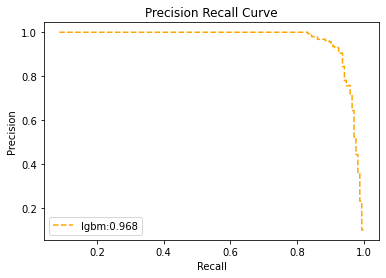

In [13]:
model = lgb.LGBMClassifier(boosting = 'gbdt',learning_rate = 0.15,random_state = 42,min_data_in_leaf = 10,max_depth = 10,num_leaves = 5)
y_pred,test_index,y_pred_hm,y_test = test_prc_models(model=[model],color_origin=['orange'],input_type=['lgbm'],file_test=[file_test])

##### 上面方程式的output值如下:
1. y_pred -> 每個病例為KD的機率值
2. test_index -> shuffle後，每筆病例對應到的原檔案index(從0開始，而非從1開始)
3. y_pred_hm -> 每個病例為KD或FC(布林值)
4. y_test ->　每個病例的真實情況為KD或FC(布林值)

##### 後續抽選錯誤病患邏輯:
1. 以y_pred_hm以及y_test做比對，找出不同的病例
2. 以不同病例所在的位置查找test_index，找到原檔案中相對應的index值
3. 從原檔案中抽取錯誤病患的特定欄位出來做劃分(這邊應該會分為KD以及FC)

In [14]:
count = 0
for i in range(len(y_pred_hm)):
    if y_pred_hm[i] != y_test[i]:
        count += 1
count

107

In [15]:
correct_kd = []
correct_fc = []
wrong_kd = []
wrong_fc = []

In [16]:
for i in range(len(y_pred_hm)):
    if y_pred_hm[i] == y_test[i]:
        if y_test[i] == 1:
            correct_kd.append(test_index[i])
        elif y_test[i] == 0:
            correct_fc.append(test_index[i])
    elif y_pred_hm[i] != y_test[i]:
        if y_test[i] == 1:
            wrong_kd.append(test_index[i])
        elif y_test[i] == 0:
            wrong_fc.append(test_index[i])
print(len(wrong_fc)+len(wrong_kd))


107


In [17]:
print(len(wrong_fc))

102


In [18]:
print(len(wrong_kd))

5


### eosinophil count

In [19]:
file_test_origin = 'D:/CODE/KD/datas/KeptGPT/k-fold/30/total-test.csv'

In [20]:
correct_kd_eosinophil_count = []
correct_fc_eosinophil_count = []
wrong_fc_eosinophil_count = []
wrong_kd_eosinophil_count = []

In [21]:
file_test_df = pd.read_csv(file_test_origin)

In [22]:
for index in wrong_fc:
    wrong_fc_eosinophil_count.append(file_test_df.iloc[int(index)]['eosinophilpcountp'])
for index in wrong_kd:
    wrong_kd_eosinophil_count.append(file_test_df.iloc[int(index)]['eosinophilpcountp'])
for index in correct_kd:
    correct_kd_eosinophil_count.append(file_test_df.iloc[int(index)]['eosinophilpcountp'])
for index in correct_fc:
    correct_fc_eosinophil_count.append(file_test_df.iloc[int(index)]['eosinophilpcountp'])

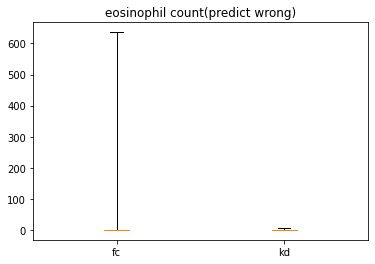

In [23]:
data = [[float(x) for x in wrong_fc_eosinophil_count],[float(x) for x in wrong_kd_eosinophil_count]]
plt.figure(1)
plt.title('eosinophil count(predict wrong)')
plt.boxplot(data,patch_artist = True,showfliers=True,whis = [0,100])
plt.xticks([1, 2], ['fc', 'kd'])
plt.show()

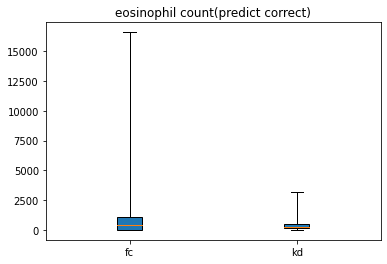

In [24]:
data = [[float(x) for x in correct_fc_eosinophil_count],[float(x) for x in correct_kd_eosinophil_count]]
plt.figure(1)
plt.title('eosinophil count(predict correct)')
plt.boxplot(data,patch_artist = True,showfliers=True,whis = [0,100])
plt.xticks([1, 2], ['fc', 'kd'])
plt.show()

### eosinophil %

In [25]:
wrong_fc_eosinophil_per = []
wrong_kd_eosinophil_per = []

correct_fc_eosinophil_per = []
correct_kd_eosinophil_per = []

file_test_df = pd.read_csv(file_test_origin)
for index in wrong_fc:
    wrong_fc_eosinophil_per.append(file_test_df.iloc[int(index)]['eosinophilp'])
for index in wrong_kd:
    wrong_kd_eosinophil_per.append(file_test_df.iloc[int(index)]['eosinophilp'])

for index in correct_fc:
    correct_fc_eosinophil_per.append(file_test_df.iloc[int(index)]['eosinophilp'])
for index in correct_kd:
    correct_kd_eosinophil_per.append(file_test_df.iloc[int(index)]['eosinophilp'])

    

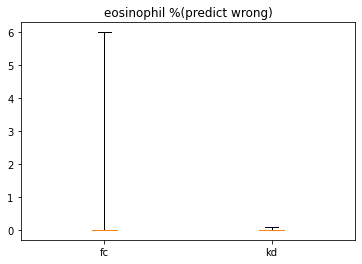

In [26]:
data = [[float(x) for x in wrong_fc_eosinophil_per],[float(x) for x in wrong_kd_eosinophil_per]]
plt.figure(1)
plt.title('eosinophil %(predict wrong)')
plt.boxplot(data,patch_artist = True,showfliers=True,whis = [0,100])
plt.xticks([1, 2], ['fc', 'kd'])
plt.show()

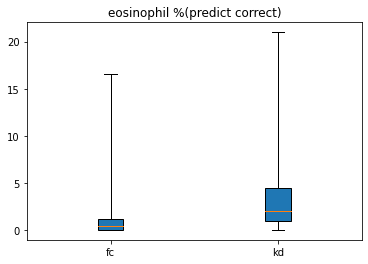

In [27]:
data = [[float(x) for x in correct_fc_eosinophil_per],[float(x) for x in correct_kd_eosinophil_per]]
plt.figure(1)
plt.title('eosinophil %(predict correct)')
plt.boxplot(data,patch_artist = True,showfliers=True,whis = [0,100])
plt.xticks([1, 2], ['fc', 'kd'])
plt.show()

### eosinophil z score

In [28]:
wrong_fc_eosinophil_z = []
wrong_kd_eosinophil_z = []

correct_fc_eosinophil_z = []
correct_kd_eosinophil_z = []

file_test_df = pd.read_csv(file_test_origin)
for index in wrong_fc:
    wrong_fc_eosinophil_z.append(file_test_df.iloc[int(index)]['EOSpzpscore'])
for index in wrong_kd:
    wrong_kd_eosinophil_z.append(file_test_df.iloc[int(index)]['EOSpzpscore'])

for index in correct_fc:
    correct_fc_eosinophil_z.append(file_test_df.iloc[int(index)]['EOSpzpscore'])
for index in correct_kd:
    correct_kd_eosinophil_z.append(file_test_df.iloc[int(index)]['EOSpzpscore'])

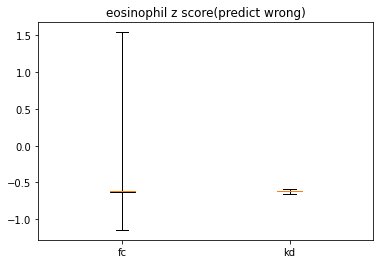

In [29]:
data = [[float(x) for x in wrong_fc_eosinophil_z],[float(x) for x in wrong_kd_eosinophil_z]]
plt.figure(1)
plt.title('eosinophil z score(predict wrong)')
plt.boxplot(data,patch_artist = True,showfliers=True,whis = [0,100])
plt.xticks([1, 2], ['fc', 'kd'])
plt.show()

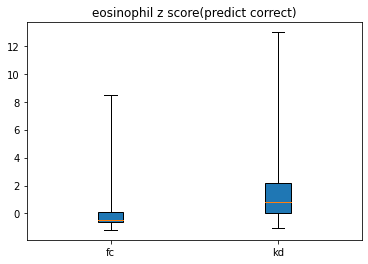

In [30]:
data = [[float(x) for x in correct_fc_eosinophil_z],[float(x) for x in correct_kd_eosinophil_z]]
plt.figure(1)
plt.title('eosinophil z score(predict correct)')
plt.boxplot(data,patch_artist = True,showfliers=True,whis = [0,100])
plt.xticks([1, 2], ['fc', 'kd'])
plt.show()

### CRP

In [31]:
wrong_fc_crp = []
wrong_kd_crp = []

correct_fc_crp = []
correct_kd_crp = []

file_test_df = pd.read_csv(file_test_origin)
for index in wrong_fc:
    wrong_fc_crp.append(file_test_df.iloc[int(index)]['CRP'])
for index in wrong_kd:
    wrong_kd_crp.append(file_test_df.iloc[int(index)]['CRP'])

for index in correct_fc:
    correct_fc_crp.append(file_test_df.iloc[int(index)]['CRP'])
for index in correct_kd:
    correct_kd_crp.append(file_test_df.iloc[int(index)]['CRP'])

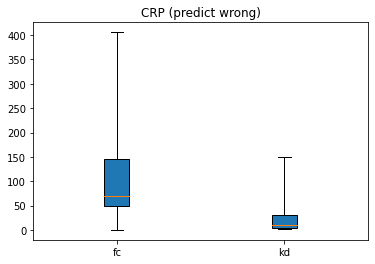

In [32]:
data = [[float(x) for x in wrong_fc_crp],[float(x) for x in wrong_kd_crp]]
plt.figure(1)
plt.title('CRP (predict wrong)')
plt.boxplot(data,patch_artist = True,showfliers=True,whis = [0,100])
plt.xticks([1, 2], ['fc', 'kd'])
plt.show()

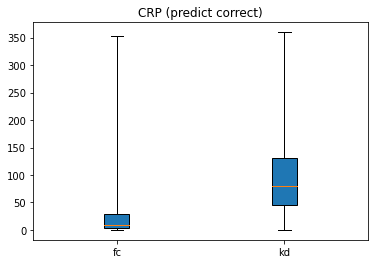

In [33]:
data = [[float(x) for x in correct_fc_crp],[float(x) for x in correct_kd_crp]]
plt.figure(1)
plt.title('CRP (predict correct)')
plt.boxplot(data,patch_artist = True,showfliers=True,whis = [0,100])
plt.xticks([1, 2], ['fc', 'kd'])
plt.show()

### ALT/GPT

In [34]:
wrong_fc_alt = []
wrong_kd_alt = []

correct_fc_alt = []
correct_kd_alt = []

file_test_df = pd.read_csv(file_test_origin)

file_test_df = file_test_df.astype({'{}'.format('ALTpGPT'):'str'})#為了下一步，要先將所有資料轉成str
file_test_df['{}'.format('ALTpGPT')] = file_test_df['{}'.format('ALTpGPT')].str.extract('(-*\d+\.*\d*)',expand = False)#內部的非數值str都remove
file_test_df = file_test_df.astype({'{}'.format('ALTpGPT'):'float'})#移除掉非數值str後將其轉回float

for index in wrong_fc:
    wrong_fc_alt.append(file_test_df.iloc[int(index)]['ALTpGPT'])
for index in wrong_kd:
    wrong_kd_alt.append(file_test_df.iloc[int(index)]['ALTpGPT'])

for index in correct_fc:
    correct_fc_alt.append(file_test_df.iloc[int(index)]['ALTpGPT'])
for index in correct_kd:
    correct_kd_alt.append(file_test_df.iloc[int(index)]['ALTpGPT'])

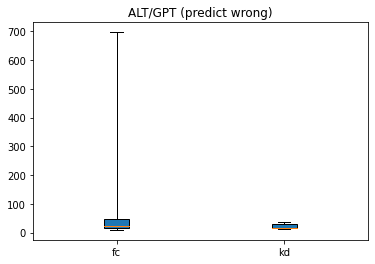

In [35]:
data = [[float(x) for x in wrong_fc_alt],[float(x) for x in wrong_kd_alt]]
plt.figure(1)
plt.title('ALT/GPT (predict wrong)')
plt.boxplot(data,patch_artist = True,showfliers=True,whis = [0,100])
plt.xticks([1, 2], ['fc', 'kd'])
plt.show()

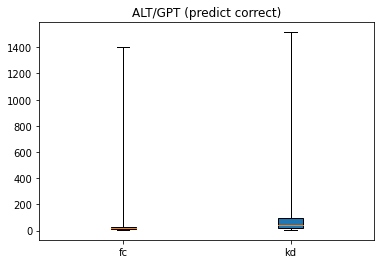

In [36]:
data = [[float(x) for x in correct_fc_alt],[float(x) for x in correct_kd_alt]]
plt.figure(1)
plt.title('ALT/GPT (predict correct)')
plt.boxplot(data,patch_artist = True,showfliers=True,whis = [0,100])
plt.xticks([1, 2], ['fc', 'kd'])
plt.show()

In [37]:
predict_wrong_df_fc = pd.DataFrame()
predict_wrong_df_kd = pd.DataFrame()
predict_wrong_df_fc['EosinophilCount'] = [float(x) for x in wrong_fc_eosinophil_count]
predict_wrong_df_kd['EosinophilCount'] = [float(x) for x in wrong_kd_eosinophil_count]

predict_wrong_df_fc['EosinophilPer'] = [float(x) for x in wrong_fc_eosinophil_per]
predict_wrong_df_kd['EosinophilPer'] = [float(x) for x in wrong_kd_eosinophil_per]

predict_wrong_df_fc['EosinophilZScore'] = [float(x) for x in wrong_fc_eosinophil_z]
predict_wrong_df_kd['EosinophilZScore'] = [float(x) for x in wrong_kd_eosinophil_z]


predict_wrong_df_fc['ALT'] = [float(x) for x in wrong_fc_alt]
predict_wrong_df_kd['ALT'] = [float(x) for x in wrong_kd_alt]


predict_wrong_df_fc['CRP'] = [float(x) for x in wrong_fc_crp]
predict_wrong_df_kd['CRP'] = [float(x) for x in wrong_kd_crp]



In [38]:
predict_wrong_df_kd

,EosinophilCount,EosinophilPer,EosinophilZScore,ALT,CRP
0,0.0,0.0,-0.610566,31.0,1.400
1,7.5,0.1,-0.592335,14.0,9.400
2,0.0,0.0,-0.610566,12.0,30.860
3,0.0,0.0,-0.610566,38.0,3.250
4,0.0,0.0,-0.658690,14.0,149.876


In [39]:
predict_correct_df_fc = pd.DataFrame()
predict_correct_df_kd = pd.DataFrame()
predict_correct_df_fc['EosinophilCount'] = [float(x) for x in correct_fc_eosinophil_count]
predict_correct_df_kd['EosinophilCount'] = [float(x) for x in correct_kd_eosinophil_count]

predict_correct_df_fc['EosinophilPer'] = [float(x) for x in correct_fc_eosinophil_per]
predict_correct_df_kd['EosinophilPer'] = [float(x) for x in correct_kd_eosinophil_per]

predict_correct_df_fc['EosinophilZScore'] = [float(x) for x in correct_fc_eosinophil_z]
predict_correct_df_kd['EosinophilZScore'] = [float(x) for x in correct_kd_eosinophil_z]


predict_correct_df_fc['ALT'] = [float(x) for x in correct_fc_alt]
predict_correct_df_kd['ALT'] = [float(x) for x in correct_kd_alt]


predict_correct_df_fc['CRP'] = [float(x) for x in correct_fc_crp]
predict_correct_df_kd['CRP'] = [float(x) for x in correct_kd_crp]

In [40]:
print(predict_correct_df_kd)

     EosinophilCount  EosinophilPer  EosinophilZScore    ALT     CRP
0             1140.0           12.0          7.846933   26.0    8.80
1              273.0            3.0          1.503809   45.0   49.40
2              276.0            3.0          1.503809   16.0   16.40
3              362.7            3.9          1.929187   10.0   61.30
4               90.0            3.0          1.503809   15.0    1.24
..               ...            ...               ...    ...     ...
163            266.0            2.0          0.668426   18.0    3.30
164            328.0            2.0          0.236490   12.0  253.10
165             37.6            0.4         -0.328649   15.0   43.60
166            300.0            4.0          2.208600   13.0   24.90
167            160.6            2.2          0.939976  201.0   79.35

[168 rows x 5 columns]


In [41]:
print(correct_kd_eosinophil_count[0:10],correct_kd_eosinophil_per[0:10],correct_kd_eosinophil_z[0:10],correct_kd_alt[0:10],correct_kd_crp[0:10])
print(predict_correct_df_kd.head(10))

[1140.0, 272.99999999999994, 275.99999999999994, 362.7000000000001, 90.0, 945.0, 587.4, 615.0000000000001, 174.0, 116.0] [12.0, 3.0, 3.0, 3.9, 3.0, 7.0, 6.6, 5.0, 2.0, 1.0] [7.8469325457395165, 1.503808977515878, 1.503808977515878, 1.9291874567563447, 1.503808977515878, 4.322975007837496, 3.645767648694541, 2.9133919926766865, 0.7990174699354737, -0.2706188098892825] [26.0, 45.0, 16.0, 10.0, 15.0, 70.0, 18.0, 41.0, 135.0, 34.0] [8.8, 49.4, 16.4, 61.3, 1.24, 99.95, 58.3, 38.91, 72.37, 100.41]
   EosinophilCount  EosinophilPer  EosinophilZScore    ALT     CRP
0           1140.0           12.0          7.846933   26.0    8.80
1            273.0            3.0          1.503809   45.0   49.40
2            276.0            3.0          1.503809   16.0   16.40
3            362.7            3.9          1.929187   10.0   61.30
4             90.0            3.0          1.503809   15.0    1.24
5            945.0            7.0          4.322975   70.0   99.95
6            587.4            6.6 

In [42]:
predict_wrong_df_fc.to_csv('D:/CODE/KD/codes/models_output/boxplot/predict_wrong_fc.csv')
predict_wrong_df_kd.to_csv('D:/CODE/KD/codes/models_output/boxplot/predict_wrong_kd.csv')
predict_correct_df_fc.to_csv('D:/CODE/KD/codes/models_output/boxplot/predict_correct_fc.csv')
predict_correct_df_kd.to_csv('D:/CODE/KD/codes/models_output/boxplot/predict_correct_kd.csv')

